### Multi-agent sample

[https://github.com/Azure-Samples/azureai-samples/blob/main/scenarios/Assistants/multi-agent](https://github.com/Azure-Samples/azureai-samples/blob/main/scenarios/Assistants/multi-agent)

In [1]:
# %pip install -r requirements.txt

In [1]:
import os
import time
from matplotlib import pyplot as plt
import cv2
import requests
from PIL import Image
from pathlib import Path

from dotenv import load_dotenv
from openai import AzureOpenAI
from openai.types.beta import Thread
from openai.types.beta import Assistant


load_dotenv()


# Create the AOAI client to use for the proxy agent.
assistant_client = AzureOpenAI(
    api_key=os.getenv("GPT4_AZURE_OPENAI_KEY"),  # Your API key for the assistant api model
    api_version=os.getenv("GPT4_AZURE_OPENAI_API_VERSION"),  # API version  (i.e. 2024-02-15-preview)
    azure_endpoint=os.getenv(
        "GPT4_AZURE_OPENAI_ENDPOINT"
    ),  # Your Azure endpoint (i.e. "https://YOURENDPOINT.openai.azure.com/")
)
# Assistant model should be '1106' or higher
assistant_deployment_name = os.getenv(
    "GPT4_DEPLOYMENT_NAME"
)  # The name of your assistant model deployment in Azure OpenAI (i.e. "GPT4Assistant")

# name of the model deployment for DALL·E 3
dalle_client = AzureOpenAI(
    api_key=os.getenv("DALLE3_AZURE_OPENAI_KEY"),
    api_version=os.getenv("DALLE3_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("DALLE3_AZURE_OPENAI_ENDPOINT"),
)
dalle_deployment_name = os.getenv("DALLE3_DEPLOYMENT_NAME")

# name of the model deployment for GPT 4 with Vision
vision_client = AzureOpenAI(
    api_key=os.getenv("GPT4VISION_AZURE_OPENAI_KEY"),
    api_version=os.getenv("GPT4VISION_AZURE_OPENAI_API_VERSION"),
    azure_endpoint=os.getenv("GPT4VISION_AZURE_OPENAI_ENDPOINT"),
)
vision_deployment_name = os.getenv("GPT4VISION_DEPLOYMENT_NAME")

### Helper functions

In [2]:
import inspect

def function_to_schema(func) -> dict:
    type_map = {
        str: "string",
        int: "integer",
        float: "number",
        bool: "boolean",
        list: "array",
        dict: "object",
        type(None): "null",
    }

    try:
        signature = inspect.signature(func)
    except ValueError as e:
        raise ValueError(
            f"Failed to get signature for function {func.__name__}: {str(e)}"
        )

    parameters = {}
    for param in signature.parameters.values():
        try:
            param_type = type_map.get(param.annotation, "string")
        except KeyError as e:
            raise KeyError(
                f"Unknown type annotation {param.annotation} for parameter {param.name}: {str(e)}"
            )
        parameters[param.name] = {"type": param_type}

    required = [
        param.name
        for param in signature.parameters.values()
        if param.default == inspect._empty
    ]

    return {
        "type": "function",
        "function": {
            "name": func.__name__,
            "description": (func.__doc__ or "").strip(),
            "parameters": {
                "type": "object",
                "properties": parameters,
                "required": required,
            },
        },
    }

In [ ]:
import json

def sample_function(param_1, param_2, the_third_one: int, some_optional="John Doe"):
    """
    This is my docstring. Call this function when you want.
    """
    print("Hello, world")

schema =  function_to_schema(sample_function)
print(json.dumps(schema, indent=2))

In [8]:
def generate_image(prompt: str) -> str:
    """
    Call the Azure OpenAI Dall-e 3 model to generate an image from a text prompt.
    Executes the call to the Azure OpenAI Dall-e 3 image creator, saves the file into the local directory, and displays the image.
    """

    print("Dalle Assistant Message: Creating the image ...")

    response = dalle_client.images.generate(
        model=dalle_deployment_name, prompt=prompt, size="1024x1024", quality="standard", n=1
    )

    # Retrieve the image URL from the response (assuming response structure)
    image_url = response.data[0].url

    # Open the image from the URL and save it to a temporary file.
    im = Image.open(requests.get(image_url, stream=True).raw)

    # Define the filename and path where the image should be saved.
    filename = "temp.jpg"
    local_path = Path(filename)

    # Save the image.
    im.save(local_path)

    # Get the absolute path of the saved image.
    full_path = str(local_path.absolute())

    img = cv2.imread("temp.jpg", cv2.IMREAD_UNCHANGED)

    # Convert the image from BGR to RGB for displaying with matplotlib,
    # because OpenCV uses BGR by default and matplotlib expects RGB.
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib.
    plt.imshow(img_rgb)
    plt.axis("off")  # Turn off axis labels.
    plt.show()

    # Return the full path of the saved image.
    print("Dalle Assistant Message: " + full_path)
    return "Image generated successfully and store in the local file system. You can now use this image to analyze it with the vision_assistant"

In [9]:
name_dl = "dalle_assistant"
instructions_dl = """As a premier AI specializing in image generation, you possess the expertise to craft precise visuals based on given prompts. It is essential that you diligently generate the requested image, ensuring its accuracy and alignment with the user's specifications, prior to delivering a response."""
tools = [ function_to_schema(generate_image)
    # {
    #     "type": "function",
    #     "function": {
    #         "name": "generate_image",
    #         "description": "Creates and displays an image",
    #         "parameters": {
    #             "type": "object",
    #             "properties": {
    #                 "prompt": {
    #                     "type": "string",
    #                     "description": "The prompt to be used to create the image",
    #                 }
    #             },
    #             "required": ["prompt"],
    #         },
    #     },
    # }
]

verbose_output = True

In [10]:
dalle_assistant = assistant_client.beta.assistants.create(
    name=name_dl, instructions=instructions_dl, model=assistant_deployment_name, tools=tools
)

In [11]:
def analyze_image() -> str:
    """
    Call the Azure OpenAI GPT4 Vision model to analyze and critic an image and return the result.The resulting output should be a new prompt for dall-e that enhances the image based on the criticism and analysis
    """
    print("Vision Assistant Message: " + "Analyzing the image...")

    import base64
    from pathlib import Path

    # Create a Path object for the image file
    image_path = Path("temp.jpg")

    # Using a context manager to open the file with Path.open()
    with image_path.open("rb") as image_file:
        base64_image = base64.b64encode(image_file.read()).decode("utf-8")

    content_images = [
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"}}
        for base64_image in [base64_image]
    ]
    response = vision_client.chat.completions.create(
        model=vision_deployment_name,
        messages=[
            {
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": "Analyze and critic this image and generate a new enhanced prompt for Dall-e with the criticism and analysis.",
                    },
                    *content_images,
                ],
            }
        ],
        max_tokens=1000,
    )
    print("Vision Assistant Message: " + response.choices[0].message.content)
    return response.choices[0].message.content

In [12]:
name_vs = "vision_assistant"
instructions_vs = """As a leading AI expert in image analysis, you excel at scrutinizing and offering critiques to refine and improve images. Your task is to thoroughly analyze an image, ensuring that all essential assessments are completed with precision before you provide feedback to the user. You have access to the local file system where the image is stored."""
tools = [ function_to_schema(analyze_image)
    # {
    #     "type": "function",
    #     "function": {
    #         "name": "analyze_image",
    #         "description": "analyzes and critics an image",
    #         "parameters": {"type": "object", "properties": {}, "required": []},
    #     },
    # }
]

verbose_output = True
vision_assistant = assistant_client.beta.assistants.create(
    name=name_vs, instructions=instructions_vs, model=assistant_deployment_name, tools=tools
)

In [13]:
from typing import Dict, Optional

agents_threads: Dict[str, Dict[str, Optional[str]]] = {
    "dalle_assistant": {"agent": dalle_assistant, "thread": None},
    "vision_assistant": {"agent": vision_assistant, "thread": None},
}

# Define the send_message function with only the query parameter
def send_message(query: str, agent_name: str) -> str:
    # Check if the agent_name is in agents_threads
    if agent_name not in agent_arr:
        print(
            f"Agent '{agent_name}' does not exist. This means that the multi-agent system does not have the necessary agent to execute the task. *** FUTURE CODE: AGENT SWARM***"
        )
        # return None
    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # If the program has not exited, proceed with setting the agent recipient
    recipient_type = agent_name
    recipient_info = agents_threads[recipient_type]

    # Create a new thread if user proxy and agent thread does not exist
    if not recipient_info["thread"]:
        thread_object = assistant_client.beta.threads.create()
        recipient_info["thread"] = thread_object

    # This function dispatches a message to the proper agent and it's thread
    return dispatch_message(query, recipient_info["agent"], recipient_info["thread"])
    # print("Proxy Assistant Message: " + message)

In [14]:
name_pa = "user_proxy"
agent_arr = ["dalle_assistant", "vision_assistant"]
agent_string = ""
for item in agent_arr:
    agent_string += f"{item}\n"

instructions_pa = f"""As a user proxy agent, your primary function is to streamline dialogue between the user and the specialized agents within this group chat. You are tasked with articulating user inquiries with clarity to the relevant agents and maintaining a steady flow of communication to guarantee the user's request is comprehensively addressed. Please withhold your response to the user until the task is completed, unless an issue is flagged by the respective agent or when you can provide a conclusive reply.

You have access to the local file system where files are stores. For example, you can access the image generated by the Dall-e assistant and send it to the Vision assistant for analysis.

You have access to the following agents to accomplish the task:
{agent_string}
If the agents above are not enough or are out of scope to complete the task, then run send_message with the name of the agent.

When outputting the agent names, use them as the basis of the agent_name in the send message function, even if the agent doesn't exist yet.

Run the send_message function for each agent name generated. 

Do not ask for followup questions, run the send_message function according to your initial input.

Plan:
1. dalle_assistant creates image 
2. vision_assistant analyzes images and creates a new prompt for dalle_assistant
3. dalle_assistant creates a new image based on the new prompt
4. vision_assistant analyzes images and creates a new prompt for dalle_assistant
5. dalle_assistant creates a new image based on the new prompt

Now take a deep breath and accomplish the plan above. Always follow the plan step by step in the exact order and do not ask for followup questions. Do not skip any steps in the plan, do not repeat any steps and always complete the entire plan in order step by step.  
The dall-e assistant can never run more than one time in a row, review your plan before running the next step.
"""

tools = [
    {"type": "code_interpreter"}, function_to_schema(send_message)
    # {
    #     "type": "function",
    #     "function": {
    #         "name": "send_message",
    #         "description": "Send messages to other agents in this group chat.",
    #         "parameters": {
    #             "type": "object",
    #             "properties": {
    #                 "query": {
    #                     "type": "string",
    #                     "description": "The message to be sent",
    #                 },
    #                 "agent_name": {
    #                     "type": "string",
    #                     "description": "The name of the agent to execute the task.",
    #                 },
    #             },
    #             "required": ["query", "agent_name"],
    #         },
    #     },
    # },
]

verbose_output = True

user_proxy = assistant_client.beta.assistants.create(
    name=name_pa, instructions=instructions_pa, model=assistant_deployment_name, tools=tools
)

In [15]:
import json


def dispatch_message(message: str, agent: Assistant, thread: Thread) -> str:
    # Loops through all the agents functions to determine which function to use

    available_functions = {}
    # Iterate through each tool in the agent.tools list
    for tool in agent.tools:
        # Check if the tool has a 'function' attribute
        if hasattr(tool, "function"):
            function_name = tool.function.name
            # Attempt to retrieve the function by its name and add it to the available_functions dictionary
            if function_name in globals():
                available_functions[function_name] = globals()[function_name]
        else:
            # Handle the case where the tool does not have a 'function' attribute
            print("This tool does not have a 'function' attribute.")
    # Draft a new message as part of the ongoing conversation.
    message = assistant_client.beta.threads.messages.create(thread_id=thread.id, role="user", content=message)
    # Carry out the tasks delineated in this discussion thread.
    run = assistant_client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=agent.id,
    )
    while True:
        # Await the completion of the thread execution.
        while run.status in ["queued", "in_progress"]:
            run = assistant_client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
            time.sleep(1)

        # If an action is necessary, initiate the appropriate function to perform the task.
        if run.status == "requires_action":
            tool_calls = run.required_action.submit_tool_outputs.tool_calls
            for _tool_call in tool_calls:
                tool_responses = []
                if (
                    run.required_action.type == "submit_tool_outputs"
                    and run.required_action.submit_tool_outputs.tool_calls is not None
                ):
                    tool_calls = run.required_action.submit_tool_outputs.tool_calls
                    for call in tool_calls:
                        if call.type == "function":
                            if call.function.name not in available_functions:
                                raise Exception("Function requested by the model does not exist")

                            # Assign the appropriate function to the agent for invocation.
                            function_to_call = available_functions[call.function.name]
                            tool_response = function_to_call(**json.loads(call.function.arguments))
                            tool_responses.append({"tool_call_id": call.id, "output": tool_response})

            # Present the outcomes produced by the tool.
            run = assistant_client.beta.threads.runs.submit_tool_outputs(
                thread_id=thread.id, run_id=run.id, tool_outputs=tool_responses
            )

        # if the run is completed, return the assistant message else provide error
        elif run.status == "failed":
            raise Exception("Run Failed. ", run.last_error)
        # Craft a reply from the assistant.
        else:
            messages = assistant_client.beta.threads.messages.list(thread_id=thread.id)

            # Transmit the response message back to the facilitating agent.
            return messages.data[0].content[0].text.value

This tool does not have a 'function' attribute.
Dalle Assistant Message: Creating the image ...


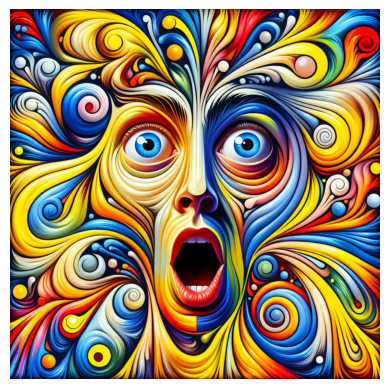

Dalle Assistant Message: c:\temp\multiAgent\temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: The vibrant colors and intricate swirls in the image create a lively and engaging background that captures attention immediately. However, the central part of the image experiences a loss of visual harmony due to the obscured section. This area interrupts the flow of the dynamic patterns and bright hues surrounding it, suggesting a need for integration or enhancement to maintain the aesthetic continuity. 

To improve the overall composition, consider prompting for a vivid abstract illustration that maintains the energetic color palette while seamlessly blending various elements into a cohesive whole. This could include inviting organic shapes and fluid textures that echo the surrounding colors, ensuring the central area is not merely a void but part of the artwork’s totality.

**Enhanced Prompt for DALL-E:**

"Create a vibrant abstract illustration filled with

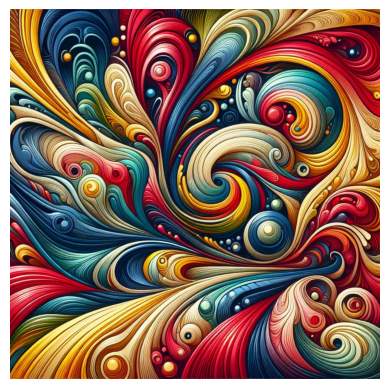

Dalle Assistant Message: c:\temp\multiAgent\temp.jpg
Vision Assistant Message: Analyzing the image...
Vision Assistant Message: ### Analysis and Critique

The image displays a vibrant and dynamic abstract composition characterized by swirling patterns and bold color contrasts. The flowing forms and intricate details create a sense of movement, while the color palette—featuring deep reds, bright yellows, and calming blues—adds energy and depth to the design. 

**Strengths:**
1. **Color Usage:** The juxtaposition of warm and cool colors creates a striking visual impact and draws the viewer's attention.
2. **Texture and Depth:** The varying textures and swirling lines give the image a three-dimensional quality, inviting viewers to explore different layers and movements.
3. **Composition:** The spiraling designs guide the viewer's eye throughout the piece, fostering a sense of relaxation and fluidity.

**Areas for Improvement:**
1. **Focal Point:** The lack of a strong focal point may make

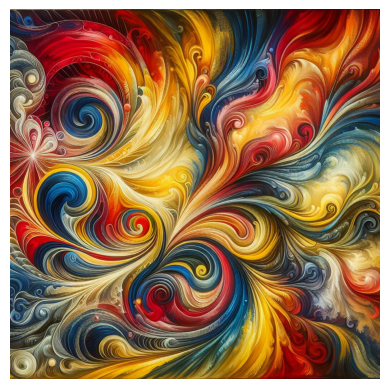

Dalle Assistant Message: c:\temp\multiAgent\temp.jpg


In [16]:
thread = assistant_client.beta.threads.create()

# Initiate proxy agent and the main thread. This thread will remain active until the task is completed and will serve as the main communication thread between the other agents.
user_message = input("User Query: ")
message = dispatch_message(user_message, user_proxy, thread)